In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torchdiffeq import odeint
from torch.nn.parameter import Parameter
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

import gpytorch

from reggae.data_loaders import load_barenco_puma, DataHolder, scaled_barenco_data

from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

In [ ]:
m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma('../data/')

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = torch.tensor(m_observed)
f_observed = torch.tensor(f_observed)
data = (m_observed, f_observed)

σ2_m_pre = f64(σ2_m_pre)
σ2_f_pre = f64(σ2_f_pre)
noise_data = (σ2_m_pre, σ2_f_pre)

print(m_observed.shape)

num_genes = m_observed.shape[1]
num_tfs = f_observed.shape[1]
N_m = m_observed.shape[2]
granularity = 100
t_start = f64(0)
t_end = f64(1)
t = torch.linspace(t_start, t_end, granularity, dtype=torch.float64).view((-1, 1))
t_inducing = torch.linspace(t_start, t_end, 7, dtype=torch.float64).reshape((-1, 1))
print(t_inducing)
plt.plot(m_observed[0,0])

In [ ]:
def positivity_transform(value):
    return torch.log(1+torch.exp(value))

def plot_genes(rtol=1e-4, atol=1e-6):
    initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64
    outputs, _ = model(t.view(-1), initial_value, rtol=rtol, atol=atol)
    outputs = torch.squeeze(outputs)
    print(outputs.shape)
    plt.figure(figsize=(5, 8))
    for i in range(num_genes):
        plt.subplot(511+i)
        plt.plot(t, torch.squeeze(outputs[0]).detach())
        plt.scatter(t_inducing, m_observed[0][i])

def plot_tfs():
    plt.figure(figsize=(5, 3))
    t_predict = torch.linspace(0, 1, 80)
    tfs = model.G(model.get_tfs(t_predict))[0].detach().numpy()
    print(tfs.shape)
    barenco_f, _ = scaled_barenco_data(tfs)
    plt.scatter(np.linspace(0,1,7), barenco_f, marker='x', s=60, linewidth=3, label='Barenco et al.')

    plt.plot(t_predict, tfs[0])
    plt.title('Latent')

In [194]:
def cholesky_inverse(cholesky_factor, upper=False):
    """Courtesy of Alex Campbell"""
    batch_shape = list(cholesky_factor.shape[:-2])
    matrix_dim = list(cholesky_factor.shape[-2:])
    if batch_shape:
        flat_batch = torch.tensor(batch_shape).prod()
        inv_cholesky_factor = torch.stack([
            torch.cholesky_inverse(
                cholesky_factor.view(-1, *matrix_dim)[l], upper=upper)
            for l in range(flat_batch)])
        matrix = inv_cholesky_factor.view(*batch_shape, *matrix_dim)
    else:
        matrix = torch.cholesky_inverse(cholesky_factor, upper=upper)
    return matrix

class ODEModel(nn.Module):
    """
    Description blah
    Parameters
    ----------
    num_genes : int
    Number of genes.
    num_tfs : int

    t_inducing : int
    inducing timepoints.
    """
    def __init__(self, num_genes, num_tfs, t_inducing):
        super(ODEModel, self).__init__()
        self.num_genes = num_genes
        self.num_tfs = num_tfs
        self.num_inducing = t_inducing.shape[0]
        self.inducing_inputs = torch.tensor(t_inducing, requires_grad=False)

        self.decay_rate = Parameter(1*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.basal_rate = Parameter(0.2*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.sensitivity = Parameter(2*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.w = Parameter(torch.ones((self.num_genes, self.num_tfs), dtype=torch.float64))
        self.w_0 = Parameter(torch.ones((self.num_tfs), dtype=torch.float64))
        self.inducing_targets = torch.randn(self.num_tfs, self.num_inducing, dtype=torch.float64) #This is not used
        # self.gp = GP(self.inducing_inputs.view(-1), self.inducing_targets, self.num_tfs)
        self.nfe = 0
        self.l2 = Parameter(0.2*torch.ones((num_tfs), dtype=torch.float64))
        self.v = Parameter(0.5 * torch.ones((num_tfs), dtype=torch.float64))
        q_m = torch.rand((self.num_tfs, self.num_inducing, 1), dtype=torch.float64) * 10 - 5
        q_K = self.rbf(self.inducing_inputs)
        # q_K = torch.eye(self.num_inducing, dtype=torch.float64).view(1, self.num_inducing, self.num_inducing)
        q_K = q_K.repeat(self.num_tfs, 1, 1)
        q_cholK = torch.cholesky(q_K)
        self.q_m = Parameter(q_m)
        #problem: q_cholS doesn't remain lower triangular (surely it should due to zero gradient in the upper triangular?)
        self.q_cholS = Parameter(q_cholK)


        self.likelihood_variance = torch.tensor(σ2_m_pre[0], requires_grad=False)
        # self.likelihood_variance = Parameter(torch.ones((self.num_genes, self.num_inducing), dtype=torch.float64))

    def rbf(self, x: torch.Tensor, x2: torch.Tensor=None):
        """
        Radial basis function kernel.
        @param x:
        @param x2: if None, then x2 becomes x
        @return: K of shape (I, |x|, |x2|)
        """
        if x2 is None:
            x2 = x
        x = x.view(-1)
        x2 = x2.view(-1)
        sq_dist = torch.square(x.view(-1, 1)-x2)
        sq_dist = sq_dist.repeat(self.num_tfs, 1, 1)
        sq_dist = torch.div(sq_dist, 2*self.l2.view((-1, 1, 1)))
        K =  self.v.view(-1, 1, 1) * torch.exp(-sq_dist)
        return K


    def forward(self, t, h, rtol=1e-4, atol=1e-6):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
        self.nfe = 0
        num_times = t.size()

        # 1: Likelihood step: Sample from variational distribution
        self.Kmm = self.rbf(self.inducing_inputs)
        L = torch.cholesky(self.Kmm)
        self.inv_Kmm = cholesky_inverse(L)
        q_cholS = torch.tril(self.q_cholS)
        self.S = torch.matmul(q_cholS, torch.transpose(q_cholS, 1, 2))

        # Integrate forward from the batch of initial positions z.
        h = odeint(self.odefunc, h, t, method='dopri5', rtol=rtol, atol=atol) # shape (num_genes, num_times, 1

        # 2: KL term:
        # above: make cholesky
        KL = -0.5 * self.num_tfs * self.num_inducing # CHECK

        # log(det(S)): (already checked, seems working)
        # Uses that sqrt(det(X)) = det(X^(1/2)) and that det of triangular matrix
        # is the product of the diagonal entries (i.e. sum of their logarithm).
        logdetS = torch.sum(torch.log(torch.diagonal(q_cholS, dim1=1, dim2=2)**2))

        # log(det(Kmm)): (already checked, seems working)
        # Uses that 0.5*|Kuu| = 0.5*|LL^T| = |L| and that det of triangular is product of diagonal.
        logdetK = torch.sum(torch.log(torch.diagonal(L, dim1=1, dim2=2)**2))
        # print('logdetK', logdetK.item(), torch.logdet(self.Kmm).item())
        # print('logdetS', logdetS.item(), torch.logdet(self.S).item())
        # tr(inv_Kmm * S):
        trKS = torch.matmul(self.inv_Kmm, self.S)
        trKS = torch.sum(torch.diagonal(trKS, dim1=1, dim2=2))

        # m^T Kuu^(-1) m:
        # cholesky_solve(b, chol)
        Kinv_m = torch.cholesky_solve(self.q_m, L, upper=False)
        m_Kinv_m = torch.matmul(torch.transpose(self.q_m, 1, 2), Kinv_m)# (1,1,1)
        m_Kinv_m = torch.squeeze(m_Kinv_m)
        #should multiply logdetK * self.num_tfs ?
        KL += 0.5 * (logdetK - logdetS + trKS + m_Kinv_m)
        # print(logdetK, logdetS, trKS, m_Kinv_m)

        return torch.transpose(h, 0, 1), KL


    def odefunc(self, t, h):
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        # h is of shape (num_genes, 1)
        decay = torch.multiply(self.decay_rate.view(-1), h.view(-1)).view(-1, 1)

        p = self.get_tfs(t.reshape(-1))
        Gp = self.G(p)
        # print(Gp.shape)
        # print(self.basal_rate, Gp, decay)

        return self.basal_rate + self.sensitivity * Gp - decay

    def get_tfs(self, t):
        Ksm = self.rbf(t, self.inducing_inputs) # (I, T*, T)
        α = torch.matmul(Ksm, self.inv_Kmm) # (I, T*, T)
        m_s = torch.matmul(α, self.q_m) # (I, T*, T*)
        Kss = self.rbf(t) # (I, T*, T*)
        jitter = 1e-6 * torch.eye(t.shape[0])
        Kss += jitter
        # I think Kss is always v: rbf with one timepoint is = ve^0
        S_Kmm = self.S - self.Kmm # (I, T, T)
        AS_KA = torch.matmul(torch.matmul(α, S_Kmm), torch.transpose(α, 1, 2)) # (I, T*, T*)
        S_s = (Kss + AS_KA) # (I, T*, T*)

        if S_s.shape[2] > 1:
            q_f = MultivariateNormal(torch.squeeze(m_s, 2), S_s)
        else:
            q_f = Normal(torch.squeeze(m_s), torch.squeeze(S_s))

        # Reparameterisation trick
        f = q_f.rsample() # TODO: multiple samples
        return f

    def G(self, p): #TODO
        return (torch.unsqueeze(p, dim=0))
        # p_pos = positivity_transform(p)
        # interactions = torch.matmul(self.w, torch.log(p_pos+1e-50)) + self.w_0 #(TODO)
        # return torch.sigmoid(interactions) # TF Activation Function (sigmoid)
        # return p

    def train(self, mode=True):
        # self.gp.train(mode)
        # self.gp.likelihood.train(mode)
        super().train(mode)

    def log_likelihood(self, y, h):
        # print(self.likelihood_variance)
        sq_diff = torch.square(y - h)
        variance = self.likelihood_variance # add PUMA variance, 0th replicate
        log_lik = -0.5*torch.log(2*3.1415926*variance) - 0.5*sq_diff/variance
        log_lik = torch.sum(log_lik)
        return log_lik
        # return MultivariateNormal(y, torch.exp(self.likelihood_variance)).log_prob(h)

In [ ]:
class Trainer():
    def __init__(self, optimizer):
        self.num_epochs = 0
        self.kl_mult = 0
        self.optimizer = optimizer
        self.losses = np.empty((0, 2))

        self.basalrates = list()
        self.decayrates = list()
        self.lengthscales = list()

    def train(self, epochs=20, report_interval=1, plot_interval=20, rtol=1e-5, atol=1e-6):
        losses = list()
        plt.figure()
        plt.plot(t_inducing, m_observed[0,0], label='real')
        end_epoch = self.num_epochs+epochs
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            # Output from model
            initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64
            output, kl = model(t_inducing.view(-1), initial_value, rtol=rtol, atol=atol)
            output = torch.squeeze(output)

            # print(model.q_cholS)
            # Calc loss and backprop gradients
            loss = -torch.sum(model.log_likelihood(m_observed[0], output))
            mult = 1
            if self.num_epochs <= 10:
                mult = self.num_epochs/10
            kl *= mult
            total_loss = loss + kl
            total_loss.backward()
            # print(model.q_cholS)
            if (epoch % report_interval) == 0:
                print('Epoch %d/%d - Loss: %.2f (%.2f %.2f) b: %.2f d %.2f s %.2f λ: %.3f' % (
                    self.num_epochs + 1, end_epoch,
                    total_loss.item(),
                    loss.item(), kl.item(),
                    model.basal_rate[0].item(),
                    model.decay_rate[0].item(),
                    model.sensitivity[0].item(),
                    model.l2.squeeze().item()
                ))
            self.optimizer.step()

            self.basalrates.append(model.basal_rate.detach().numpy())
            self.decayrates.append(model.decay_rate.detach().numpy())
            self.lengthscales.append(model.l2.squeeze().item())
            losses.append((loss.item(), kl.item()))
            with torch.no_grad():
                model.l2.clamp_(0.001, 0.5)
                model.sensitivity.clamp_(0.4, 8)
                model.basal_rate.clamp_(0, 8)
                model.decay_rate.clamp_(0, 8)
                model.sensitivity[3] = np.float64(1.)
                model.decay_rate[3] = np.float64(0.8)
                # model.q_cholS = torch.tril(model.q_cholS)


            if (epoch % plot_interval) == 0:
                plt.plot(t_inducing, output[0].detach().numpy(), label='epoch'+str(epoch))
            self.num_epochs += 1
        plt.legend()

        losses = np.array(losses)
        self.losses = np.concatenate([self.losses, losses], axis=0)

        return output

In [197]:
model = ODEModel(num_genes, num_tfs, t_inducing)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
trainer = Trainer(optimizer)
# list(model.parameters())

/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### Outputs prior to training:

torch.Size([5, 100])
(1, 80)


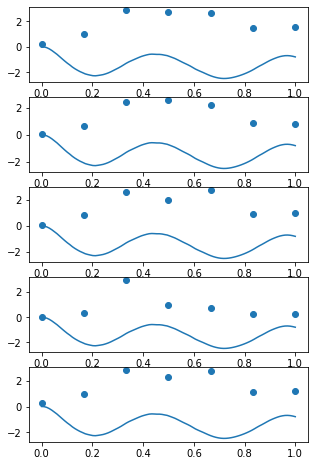

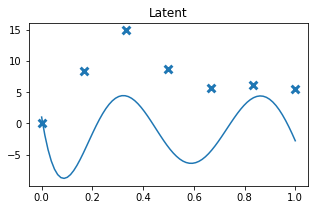

In [198]:
plot_genes(rtol=1e-3, atol=1e-4)
plot_tfs()

Epoch 1/280 - Loss: 2373.69 (2373.69 0.00) b: 0.20 d 1.00 s 2.00 λ: 0.200
Epoch 11/280 - Loss: 665.72 (593.69 72.03) b: 0.67 d 1.41 s 1.56 λ: 0.001
Epoch 21/280 - Loss: 546.24 (483.62 62.62) b: 1.06 d 1.57 s 1.31 λ: 0.001
Epoch 31/280 - Loss: 475.28 (416.22 59.06) b: 1.42 d 1.60 s 1.13 λ: 0.001
Epoch 41/280 - Loss: 408.25 (351.34 56.91) b: 1.75 d 1.56 s 1.01 λ: 0.001
Epoch 51/280 - Loss: 373.61 (318.00 55.60) b: 2.07 d 1.45 s 0.92 λ: 0.001
Epoch 61/280 - Loss: 317.96 (263.17 54.79) b: 2.38 d 1.30 s 0.80 λ: 0.001
Epoch 71/280 - Loss: 274.53 (220.37 54.16) b: 2.67 d 1.13 s 0.68 λ: 0.001
Epoch 81/280 - Loss: 262.03 (208.52 53.51) b: 2.92 d 0.96 s 0.57 λ: 0.001


KeyboardInterrupt: 

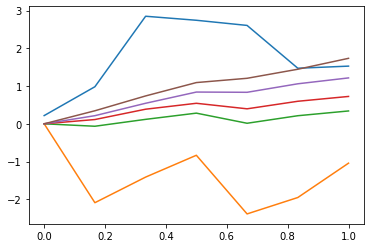

In [199]:
tol = 1e-3
# trainer = Trainer(optimizer)

output = trainer.train(280, rtol=tol, atol=tol/10, report_interval=10)

### Outputs after training

torch.Size([5, 100])
(1, 80)


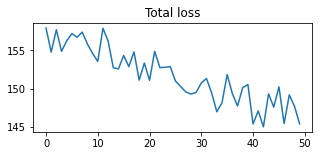

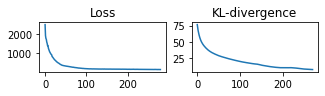

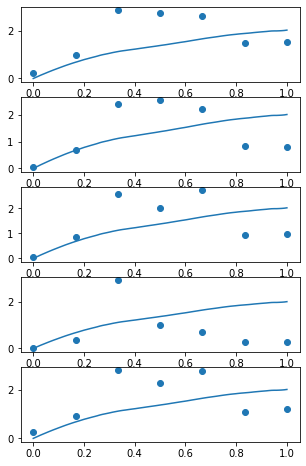

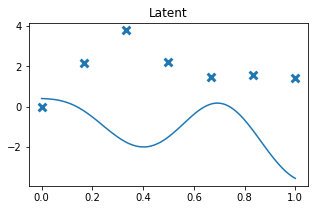

In [185]:
plt.figure(figsize=(5, 2))
plt.plot(np.sum(trainer.losses, axis=1)[-50:])
plt.title('Total loss')
plt.figure(figsize=(5, 2))
plt.subplot(221)
plt.plot(trainer.losses[:, 0])
plt.title('Loss')
plt.subplot(222)
plt.plot(trainer.losses[10:, 1])
plt.title('KL-divergence')

plot_genes(rtol=1e-3, atol=1e-4)
# plot_genes(rtol=1e-5, atol=1e-6)
plot_tfs()

torch.Size([1, 7, 1])
Parameter containing:
tensor([[-1.5246, -3.4225,  0.5453,  0.4558, -0.8991,  0.1822, -2.0911],
        [-2.7409, -0.6415,  0.3184,  0.4650, -2.0896,  0.5004, -2.0094],
        [-3.0729, -0.4409,  0.2341, -0.3513, -1.8795,  0.8146, -1.7812],
        [-3.9272, -4.1301,  0.9394, -0.5000, -3.4205, -0.6667, -3.3327],
        [-1.3829, -3.4332,  0.5892,  0.2126, -0.2391,  0.2169, -2.1182]],
       dtype=torch.float64, requires_grad=True)


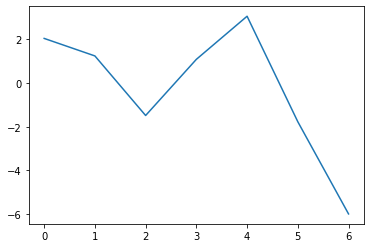

In [134]:
print(model.q_m.shape)
print(model.likelihood_variance)
plt.plot(model.q_m[0,:,0].detach())

In [ ]:
plt.figure(figsize=(5, 6))
_, basal, decay, lengthscale = params
basals = np.array(basal)
decays = np.array(decay)
lengthscales = np.array(lengthscale)
print(lengthscales.shape)
plt.subplot(311)
# print(basals[:,0])
plt.plot(basals[:,0])
# plt.ylim(1, 1.5)
plt.subplot(312)
plt.plot(decays[:,0])
# plt.ylim(0.5, 1)
plt.subplot(313)
plt.plot(lengthscales)
# plt.ylim(1, 1.2)

print(model.basal_rate)


In [ ]:
model.sensitivity
# model.gp.covar_module.outputscale